# Install Necessary Libraries

In [1]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade scikit-learn imbalanced-learn optuna joblib matplotlib pandas numpy

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\python\python.exe -m pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Configuration and Optimization (For Realistic Mode)

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, classification_report,
    matthews_corrcoef, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import joblib
import optuna
from optuna.samplers import TPESampler

# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODE = "realistic"       # "realistic" drops CA/PA, "full" keeps them
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
N_TRIALS = 100


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat',"Age"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# drop CA/PA if realistic
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)


# ==============================================================================
# SMOTE and Hyperparameters
# ==============================================================================


def rf_objective(trial):
    smote_level = trial.suggest_categorical("smote_level", ["small", "medium", "high"])
    smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[smote_level]

    # Random Forest hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    # optional class_weight for imbalance
    use_class_weight = trial.suggest_categorical("use_class_weight", [False, True])
    class_weight = "balanced" if use_class_weight else None

    smote = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

    # For RandomForest scaling is not required
    pipe = ImbPipeline([
        ("smote", smote),
        ("clf", RandomForestClassifier(
            random_state=SEED,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            class_weight=class_weight,
            n_jobs=-1
        ))
    ])

    # train on training set
    pipe.fit(X_train, y_train)
    y_val_proba = pipe.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= 0.5).astype(int)

    return balanced_accuracy_score(y_val, y_val_pred)


# Run Optuna for Random Forest
study_rf = optuna.create_study(direction="maximize", sampler=TPESampler(seed=SEED), study_name="RF_Realistic")
study_rf.optimize(rf_objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params_rf = study_rf.best_params
best_value_rf = study_rf.best_value
print("\nRandom Forest - Best Hyperparameters:", best_params_rf)
print("Random Forest - Best Validation Balanced Accuracy (Optuna):", best_value_rf)

# Build final pipeline with best RF params
best_smote_rf = SMOTE(
    sampling_strategy={"small": 0.2, "medium": 0.5, "high": 1.0}[best_params_rf["smote_level"]],
    random_state=SEED
)

rf_clf = RandomForestClassifier(
    random_state=SEED,
    n_estimators=best_params_rf["n_estimators"],
    max_depth=best_params_rf["max_depth"],
    min_samples_split=best_params_rf["min_samples_split"],
    min_samples_leaf=best_params_rf["min_samples_leaf"],
    max_features=best_params_rf["max_features"],
    bootstrap=best_params_rf["bootstrap"],
    class_weight=("balanced" if best_params_rf.get("use_class_weight", False) else None),
    n_jobs=-1
)

final_pipe_rf = ImbPipeline([
    ("smote", best_smote_rf),
    ("clf", rf_clf)
])

# Retrain final RF on Train + Val
final_pipe_rf.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

Reading file...


[I 2025-12-06 20:35:17,679] A new study created in memory with name: RF_Realistic


Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=realistic -> Dropped CA and PA

Features: 62  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-06 20:35:20,455] Trial 0 finished with value: 0.8029572495246071 and parameters: {'smote_level': 'medium', 'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'use_class_weight': True}. Best is trial 0 with value: 0.8029572495246071.
[I 2025-12-06 20:35:22,204] Trial 1 finished with value: 0.7279760035589051 and parameters: {'smote_level': 'medium', 'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'use_class_weight': True}. Best is trial 0 with value: 0.8029572495246071.
[I 2025-12-06 20:35:25,910] Trial 2 finished with value: 0.6300581375063241 and parameters: {'smote_level': 'small', 'n_estimators': 400, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'use_class_weight': False}. Best is trial 0 with value: 0.8029572495246071.
[I 2025-12-06 20:35:40,560] Trial 3 f

,steps,"[('smote', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,0.2
,random_state,67
,k_neighbors,5
,n_estimators,450
,criterion,'gini'
,max_depth,6
,min_samples_split,6


# Plot The Visualization History for the Optuna Realistic Mode

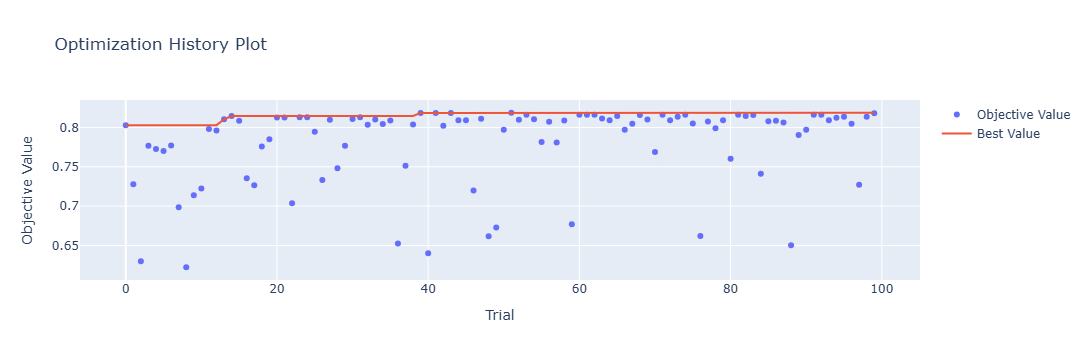

In [3]:
fig1 = optuna.visualization.plot_optimization_history(study_rf)
fig1.write_html("optimization_history_realistic.html")
fig1.show()

# Best Tuned Hyperparamter on Realistic Mode

In [4]:
print(study_rf.best_value)
best_params_rf

0.8187368067549414


{'smote_level': 'small',
 'n_estimators': 450,
 'max_depth': 6,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'bootstrap': True,
 'use_class_weight': True}

# FINAL EVALUATION ON TEST (with both thresholds) for the Realistic Mode

In [5]:
# =========================
# FINAL EVALUATION ON TEST (RF) — same two thresholds approach
# =========================

y_test_pred_prop_rf = final_pipe_rf.predict_proba(X_test)[:, 1]

# find thresholds
thresholds_rf = {"F1": None, "Balanced_Accuracy": None}
best_f1_rf = 0
best_bal_rf = 0

for t in np.arange(0.1, 0.91, 0.01):
    y_pred_t = (y_test_pred_prop_rf >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t)
    bal_t = balanced_accuracy_score(y_test, y_pred_t)

    if f1_t > best_f1_rf:
        best_f1_rf = f1_t
        thresholds_rf["F1"] = t
    if bal_t > best_bal_rf:
        best_bal_rf = bal_t
        thresholds_rf["Balanced_Accuracy"] = t

# predictions
y_pred_f1_rf = (y_test_pred_prop_rf >= thresholds_rf["F1"]).astype(int)
y_pred_bal_rf = (y_test_pred_prop_rf >= thresholds_rf["Balanced_Accuracy"]).astype(int)

# metrics dicts
metrics_f1_rf = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_f1_rf),
    "precision": precision_score(y_test, y_pred_f1_rf),
    "recall": recall_score(y_test, y_pred_f1_rf),
    "f1": f1_score(y_test, y_pred_f1_rf),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_rf),
    "geometric_mean": geometric_mean_score(y_test, y_pred_f1_rf),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_f1_rf),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_f1_rf)
}

metrics_bal_rf = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_bal_rf),
    "precision": precision_score(y_test, y_pred_bal_rf),
    "recall": recall_score(y_test, y_pred_bal_rf),
    "f1": f1_score(y_test, y_pred_bal_rf),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_rf),
    "geometric_mean": geometric_mean_score(y_test, y_pred_bal_rf),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_bal_rf),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_bal_rf)
}

# print RF results
print("\nFINAL EVALUATION ON TEST SET (Random Forest)")
print("="*70)

print(f"\nUsing F1 Threshold ({thresholds_rf['F1']:.3f})")
print(f"Balanced Accuracy: {metrics_f1_rf['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_f1_rf['precision']:.4f}")
print(f"Recall: {metrics_f1_rf['recall']:.4f}")
print(f"F1 Score: {metrics_f1_rf['f1']:.4f}")
print(f"ROC-AUC: {metrics_f1_rf['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_f1_rf['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_f1_rf['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_f1_rf['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_f1_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_f1_rf))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_f1_rf))

print(f"\nUsing Balanced Accuracy Threshold ({thresholds_rf['Balanced_Accuracy']:.3f})")
print(f"Balanced Accuracy: {metrics_bal_rf['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_bal_rf['precision']:.4f}")
print(f"Recall: {metrics_bal_rf['recall']:.4f}")
print(f"F1 Score: {metrics_bal_rf['f1']:.4f}")
print(f"ROC-AUC: {metrics_bal_rf['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_bal_rf['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_bal_rf['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_bal_rf['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal_rf))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_bal_rf))

# Save RF model dict
model_dict_rf = {
    "best_params": best_params_rf,
    "best_value": best_value_rf,
    "thresholds": thresholds_rf,
    "metrics_f1": metrics_f1_rf,
    "metrics_balanced_accuracy": metrics_bal_rf,
    "study": study_rf,
    "model": final_pipe_rf
}

joblib.dump(model_dict_rf, "RF_realistic_model.pkl")


FINAL EVALUATION ON TEST SET (Random Forest)

Using F1 Threshold (0.710)
Balanced Accuracy: 0.7098
Precision: 0.2269
Recall: 0.4747
F1 Score: 0.3070
ROC-AUC: 0.8889
Geometric Mean: 0.6697
Matthews Corr: 0.2956
Cohen Kappa: 0.2747

Confusion Matrix:
 [[6018  351]
 [ 114  103]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      6369
           1       0.23      0.47      0.31       217

    accuracy                           0.93      6586
   macro avg       0.60      0.71      0.63      6586
weighted avg       0.96      0.93      0.94      6586


Imbalanced Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.94      0.47      0.96      0.67      0.47      6369
          1       0.23      0.47      0.94      0.31      0.67      0.43       217

avg / total       0.96      0.93      0.49      0.94      0.67      0.47      6586


Using Balance

['RF_realistic_model.pkl']

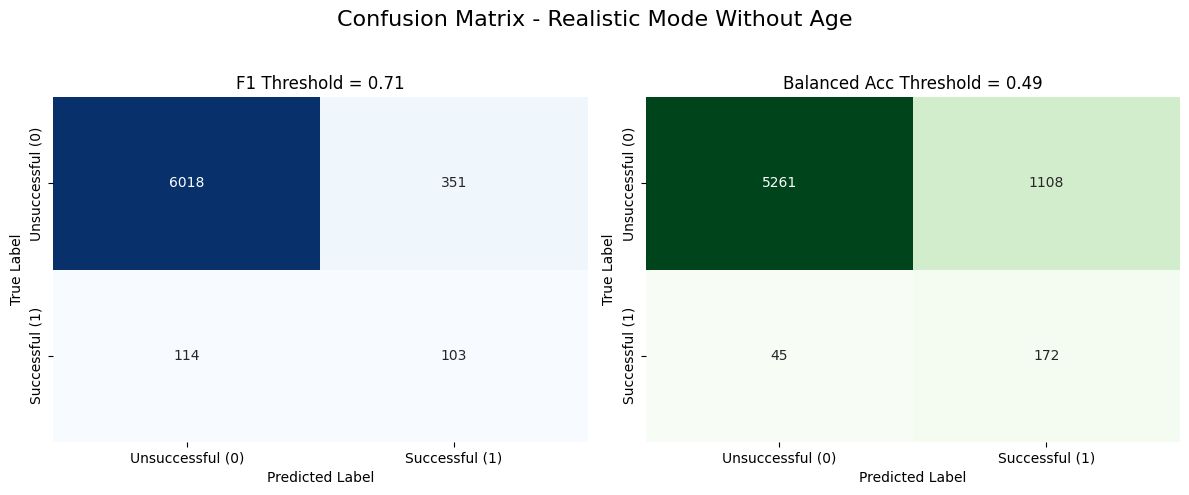

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# CONFUSION MATRIX PLOTS SIDE BY SIDE
# ==============================================================================

# Compute confusion matrices
cm_f1 = confusion_matrix(y_test, y_pred_f1_rf)
cm_bal = confusion_matrix(y_test, y_pred_bal_rf)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# F1 Threshold
sns.heatmap(cm_f1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[0])
axes[0].set_title(f"F1 Threshold = {thresholds_rf['F1']:.2f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Balanced Accuracy Threshold
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[1])
axes[1].set_title(f"Balanced Acc Threshold = {thresholds_rf['Balanced_Accuracy']:.2f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Overall title
plt.suptitle("Confusion Matrix - Realistic Mode Without Age", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("Confusion Matrix - Realistic Mode")
plt.show()

# Data Configuration and Optimization (For Full Mode)

In [7]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, classification_report,
    matthews_corrcoef, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import joblib
import optuna
from optuna.samplers import TPESampler

# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODE = "full"       # "realistic" drops CA/PA, "full" keeps them
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
N_TRIALS = 100


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat',"Age"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# drop CA/PA if realistic
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)


# ==============================================================================
# SMOTE and Hyperparameters
# ==============================================================================

def rf_objective(trial):
    smote_level = trial.suggest_categorical("smote_level", ["small", "medium", "high"])
    smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[smote_level]

    # Random Forest hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    # optional class_weight for imbalance
    use_class_weight = trial.suggest_categorical("use_class_weight", [False, True])
    class_weight = "balanced" if use_class_weight else None

    smote = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

    # For RandomForest scaling is not required, but keeping StandardScaler doesn't hurt.
    pipe = ImbPipeline([
        ("smote", smote),
        ("clf", RandomForestClassifier(
            random_state=SEED,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            class_weight=class_weight,
            n_jobs=-1
        ))
    ])

    # train on training set
    pipe.fit(X_train, y_train)
    y_val_proba = pipe.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= 0.5).astype(int)

    return balanced_accuracy_score(y_val, y_val_pred)


# Run Optuna for Random Forest
study_rf = optuna.create_study(direction="maximize", sampler=TPESampler(seed=SEED), study_name="RF_Full")
study_rf.optimize(rf_objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params_rf = study_rf.best_params
best_value_rf = study_rf.best_value
print("\nRandom Forest - Best Hyperparameters:", best_params_rf)
print("Random Forest - Best Validation Balanced Accuracy (Optuna):", best_value_rf)

# Build final pipeline with best RF params
best_smote_rf = SMOTE(
    sampling_strategy={"small": 0.2, "medium": 0.5, "high": 1.0}[best_params_rf["smote_level"]],
    random_state=SEED
)

# construct RF classifier with tuned params (handle class_weight key if present)
rf_clf = RandomForestClassifier(
    random_state=SEED,
    n_estimators=best_params_rf["n_estimators"],
    max_depth=best_params_rf["max_depth"],
    min_samples_split=best_params_rf["min_samples_split"],
    min_samples_leaf=best_params_rf["min_samples_leaf"],
    max_features=best_params_rf["max_features"],
    bootstrap=best_params_rf["bootstrap"],
    class_weight=("balanced" if best_params_rf.get("use_class_weight", False) else None),
    n_jobs=-1
)

final_pipe_rf = ImbPipeline([
    ("smote", best_smote_rf),
    ("clf", rf_clf)
])

# Retrain final RF on Train + Val
final_pipe_rf.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

Reading file...


[I 2025-12-06 20:49:36,374] A new study created in memory with name: RF_Full


Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=full -> Keeping CA and PA

Features: 66  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-06 20:49:41,692] Trial 0 finished with value: 0.8283864116118003 and parameters: {'smote_level': 'medium', 'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'use_class_weight': True}. Best is trial 0 with value: 0.8283864116118003.
[I 2025-12-06 20:49:43,645] Trial 1 finished with value: 0.769528183388287 and parameters: {'smote_level': 'medium', 'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'use_class_weight': True}. Best is trial 0 with value: 0.8283864116118003.
[I 2025-12-06 20:49:47,221] Trial 2 finished with value: 0.6887135604752185 and parameters: {'smote_level': 'small', 'n_estimators': 400, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'use_class_weight': False}. Best is trial 0 with value: 0.8283864116118003.
[I 2025-12-06 20:50:02,411] Trial 3 fi

,steps,"[('smote', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,1.0
,random_state,67
,k_neighbors,5
,n_estimators,750
,criterion,'gini'
,max_depth,6
,min_samples_split,9


# Plot The Visualization History for the Optuna Full Mode

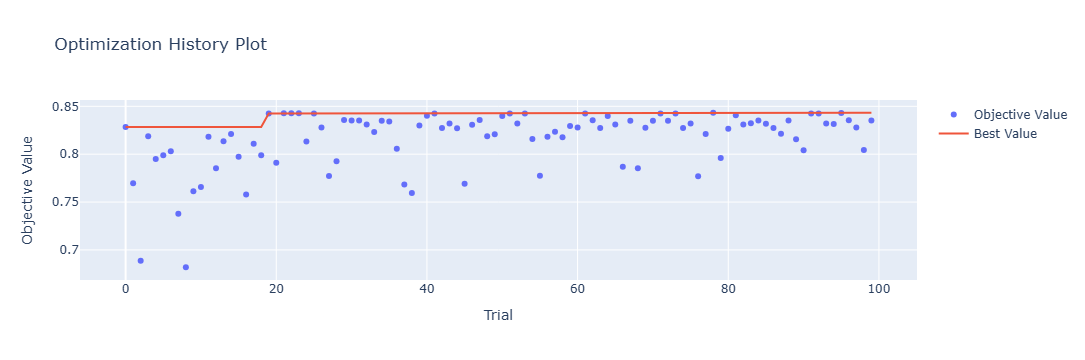

In [8]:
fig2 = optuna.visualization.plot_optimization_history(study_rf)
fig2.write_html("optimization_history_full.html")
fig2.show()

# Best Tuned Hyperparamter on Full Mode

In [9]:
print(study_rf.best_value)
best_params_rf

0.8432620680030006


{'smote_level': 'high',
 'n_estimators': 750,
 'max_depth': 6,
 'min_samples_split': 9,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'bootstrap': True,
 'use_class_weight': True}

# FINAL EVALUATION ON TEST (with both thresholds) for the Full Mode

In [10]:
# ==============================================================================
# Evaluate on test set with two thresholds
# ==============================================================================
y_test_pred_prop = final_pipe_rf.predict_proba(X_test)[:, 1]

# Initialize thresholds
thresholds_rf = {"F1": None, "Balanced_Accuracy": None}
best_f1_rf = 0
best_bal_rf = 0

# Search for thresholds
for t in np.arange(0.1, 0.91, 0.01):
    y_pred_t = (y_test_pred_prop >= t).astype(int)

    # F1 score
    f1_t = f1_score(y_test, y_pred_t)
    if f1_t > best_f1_rf:
        best_f1_rf = f1_t
        thresholds_rf["F1"] = t

    # Balanced Accuracy
    bal_t = balanced_accuracy_score(y_test, y_pred_t)
    if bal_t > best_bal_rf:
        best_bal_rf = bal_t
        thresholds_rf["Balanced_Accuracy"] = t

# Predictions using both thresholds
y_pred_f1_rf = (y_test_pred_prop >= thresholds_rf['F1']).astype(int)
y_pred_bal_rf = (y_test_pred_prop >= thresholds_rf['Balanced_Accuracy']).astype(int)

# Metrics for both thresholds
metrics_f1_rf = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_f1_rf),
    "precision": precision_score(y_test, y_pred_f1_rf),
    "recall": recall_score(y_test, y_pred_f1_rf),
    "f1": f1_score(y_test, y_pred_f1_rf),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop),
    "geometric_mean": geometric_mean_score(y_test, y_pred_f1_rf),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_f1_rf),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_f1_rf)
}

metrics_bal_rf = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_bal_rf),
    "precision": precision_score(y_test, y_pred_bal_rf),
    "recall": recall_score(y_test, y_pred_bal_rf),
    "f1": f1_score(y_test, y_pred_bal_rf),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop),
    "geometric_mean": geometric_mean_score(y_test, y_pred_bal_rf),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_bal_rf),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_bal_rf)
}

# Print results
print("\nFINAL EVALUATION ON TEST SET - RANDOM FOREST (FULL MODE)")
print("="*70)

#  F1-optimal threshold
print(f"\nUsing F1 Threshold ({thresholds_rf['F1']:.3f})")
print(f"Balanced Accuracy: {metrics_f1_rf['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_f1_rf['precision']:.4f}")
print(f"Recall: {metrics_f1_rf['recall']:.4f}")
print(f"F1 Score: {metrics_f1_rf['f1']:.4f}")
print(f"ROC-AUC: {metrics_f1_rf['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_f1_rf['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_f1_rf['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_f1_rf['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_f1_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_f1_rf))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_f1_rf))

# Balanced Accuracy-optimal threshold
print(f"\nUsing Balanced Accuracy Threshold ({thresholds_rf['Balanced_Accuracy']:.3f})")
print(f"Balanced Accuracy: {metrics_bal_rf['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_bal_rf['precision']:.4f}")
print(f"Recall: {metrics_bal_rf['recall']:.4f}")
print(f"F1 Score: {metrics_bal_rf['f1']:.4f}")
print(f"ROC-AUC: {metrics_bal_rf['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_bal_rf['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_bal_rf['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_bal_rf['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal_rf))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_bal_rf))

# Save final model and metrics
model_dict_rf = {
    "best_params": best_params_rf,
    "thresholds": thresholds_rf,
    "metrics_f1": metrics_f1_rf,
    "metrics_balanced_accuracy": metrics_bal_rf,
    "study": study_rf,
    "model": final_pipe_rf
}

joblib.dump(model_dict_rf, "RF_full_model.pkl")


FINAL EVALUATION ON TEST SET - RANDOM FOREST (FULL MODE)

Using F1 Threshold (0.780)
Balanced Accuracy: 0.6928
Precision: 0.3633
Recall: 0.4101
F1 Score: 0.3853
ROC-AUC: 0.9132
Geometric Mean: 0.6325
Matthews Corr: 0.3637
Cohen Kappa: 0.3630

Confusion Matrix:
 [[6213  156]
 [ 128   89]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      6369
           1       0.36      0.41      0.39       217

    accuracy                           0.96      6586
   macro avg       0.67      0.69      0.68      6586
weighted avg       0.96      0.96      0.96      6586


Imbalanced Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.98      0.41      0.98      0.63      0.42      6369
          1       0.36      0.41      0.98      0.39      0.63      0.38       217

avg / total       0.96      0.96      0.43      0.96      0.63      0.42      6586


U

['RF_full_model.pkl']

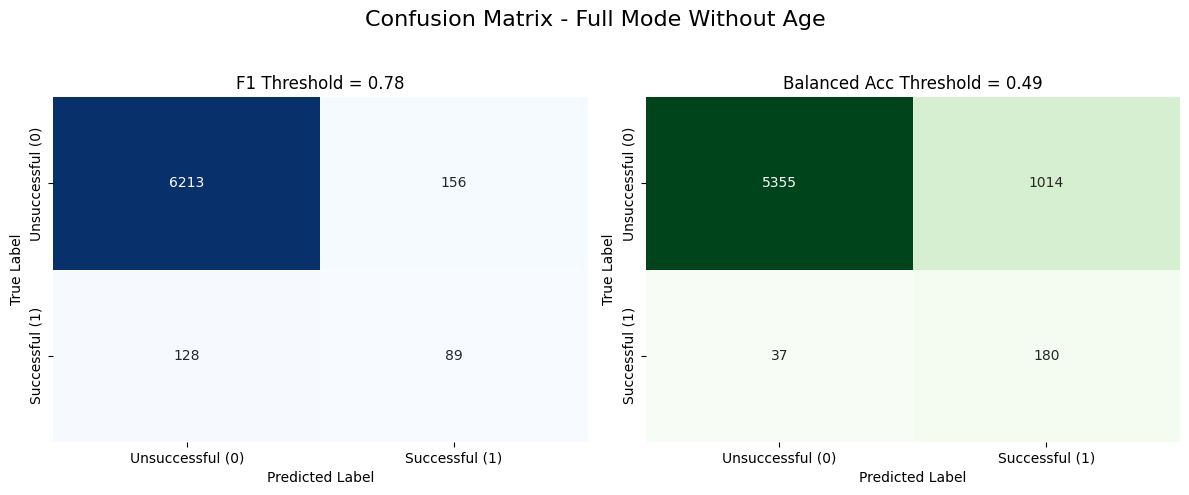

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# CONFUSION MATRIX PLOTS SIDE BY SIDE
# ==============================================================================

# Compute confusion matrices
cm_f1 = confusion_matrix(y_test, y_pred_f1_rf)
cm_bal = confusion_matrix(y_test, y_pred_bal_rf)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# F1 Threshold
sns.heatmap(cm_f1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[0])
axes[0].set_title(f"F1 Threshold = {thresholds_rf['F1']:.2f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Balanced Accuracy Threshold
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[1])
axes[1].set_title(f"Balanced Acc Threshold = {thresholds_rf['Balanced_Accuracy']:.2f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Overall title
plt.suptitle("Confusion Matrix - Full Mode Without Age", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("Confusion Matrix - Full Mode")
plt.show()

# visualize the comparison of the models based on different metrics.

In [1]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade scikit-learn imbalanced-learn optuna joblib matplotlib pandas numpy

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\python\python.exe -m pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import joblib

# Load the realistic mode model
rf_realistic_model = joblib.load("RF_realistic_model.pkl")

# Load the full mode model
rf_full_model = joblib.load("RF_full_model.pkl")

print("Realistic Model Metrics (F1 Optimal Threshold):")
print(rf_realistic_model['metrics_f1'])

print("\nFull Model Metrics (F1 Optimal Threshold):")
print(rf_full_model['metrics_f1'])

print("\nRealistic Model Metrics (Balanced Accuracy Optimal Threshold):")
print(rf_realistic_model['metrics_balanced_accuracy'])

print("\nFull Model Metrics (Balanced Accuracy Optimal Threshold):")
print(rf_full_model['metrics_balanced_accuracy'])

Realistic Model Metrics (F1 Optimal Threshold):
{'balanced_accuracy': 0.7097718427318962, 'precision': 0.22687224669603523, 'recall': 0.47465437788018433, 'f1': 0.30700447093889716, 'roc_auc': 0.8889371256076922, 'geometric_mean': np.float64(0.6696983249618709), 'matthews_corrcoef': 0.2956062967409064, 'cohen_kappa': 0.27466444979714233}

Full Model Metrics (F1 Optimal Threshold):
{'balanced_accuracy': 0.6928223038869872, 'precision': 0.363265306122449, 'recall': 0.41013824884792627, 'f1': 0.3852813852813853, 'roc_auc': 0.913223831157978, 'geometric_mean': np.float64(0.6325286315969784), 'matthews_corrcoef': 0.36373981021554136, 'cohen_kappa': 0.3630218205817869}

Realistic Model Metrics (Balanced Accuracy Optimal Threshold):
{'balanced_accuracy': 0.8093295361388291, 'precision': 0.134375, 'recall': 0.7926267281105991, 'f1': 0.22979291917167669, 'roc_auc': 0.8889371256076922, 'geometric_mean': np.float64(0.8091571628989417), 'matthews_corrcoef': 0.27907971429719486, 'cohen_kappa': 0.18

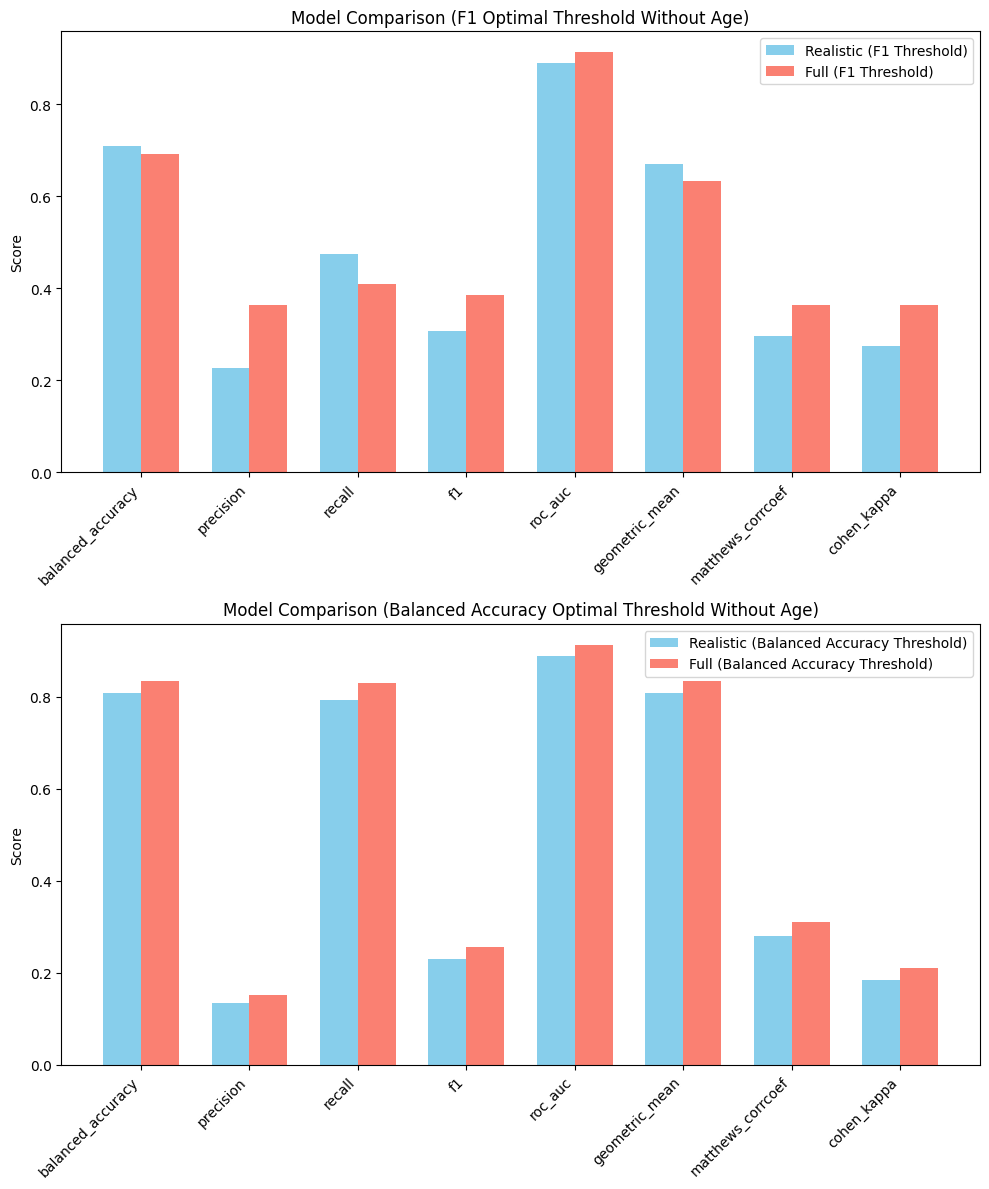

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract metrics for comparison
metrics_f1_realistic = rf_realistic_model['metrics_f1']
metrics_f1_full = rf_full_model['metrics_f1']
metrics_bal_realistic = rf_realistic_model['metrics_balanced_accuracy']
metrics_bal_full = rf_full_model['metrics_balanced_accuracy']

# Create DataFrames for easier plotting
df_f1 = pd.DataFrame({
    "Metric": metrics_f1_realistic.keys(),
    "Realistic (F1 Threshold)": metrics_f1_realistic.values(),
    "Full (F1 Threshold)": metrics_f1_full.values()
})

df_bal = pd.DataFrame({
    "Metric": metrics_bal_realistic.keys(),
    "Realistic (Balanced Accuracy Threshold)": metrics_bal_realistic.values(),
    "Full (Balanced Accuracy Threshold)": metrics_bal_full.values()
})

# Create a 2x1 grid of plots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plotting F1-optimal threshold metrics in the first subplot
bar_width = 0.35
x_f1 = np.arange(len(df_f1["Metric"]))

rects1_f1 = axes[0].bar(x_f1 - bar_width/2, df_f1["Realistic (F1 Threshold)"], bar_width, label='Realistic (F1 Threshold)', color='skyblue')
rects2_f1 = axes[0].bar(x_f1 + bar_width/2, df_f1["Full (F1 Threshold)"], bar_width, label='Full (F1 Threshold)', color='salmon')

axes[0].set_ylabel("Score")
axes[0].set_title("Model Comparison (F1 Optimal Threshold Without Age)")
axes[0].set_xticks(x_f1)
axes[0].set_xticklabels(df_f1["Metric"], rotation=45, ha='right')
axes[0].legend()

# Plotting Balanced Accuracy-optimal threshold metrics in the second subplot
bar_width = 0.35
x_bal = np.arange(len(df_bal["Metric"]))

rects1_bal = axes[1].bar(x_bal - bar_width/2, df_bal["Realistic (Balanced Accuracy Threshold)"], bar_width, label='Realistic (Balanced Accuracy Threshold)', color='skyblue')
rects2_bal = axes[1].bar(x_bal + bar_width/2, df_bal["Full (Balanced Accuracy Threshold)"], bar_width, label='Full (Balanced Accuracy Threshold)', color='salmon')

axes[1].set_ylabel("Score")
axes[1].set_title("Model Comparison (Balanced Accuracy Optimal Threshold Without Age)")
axes[1].set_xticks(x_bal)
axes[1].set_xticklabels(df_bal["Metric"], rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
# Save the combined 2x1 plot
plt.savefig("model_comparison_2x1_grid.png")
plt.show()

Reading file...
Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=full -> Keeping CA and PA

Features: 66  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


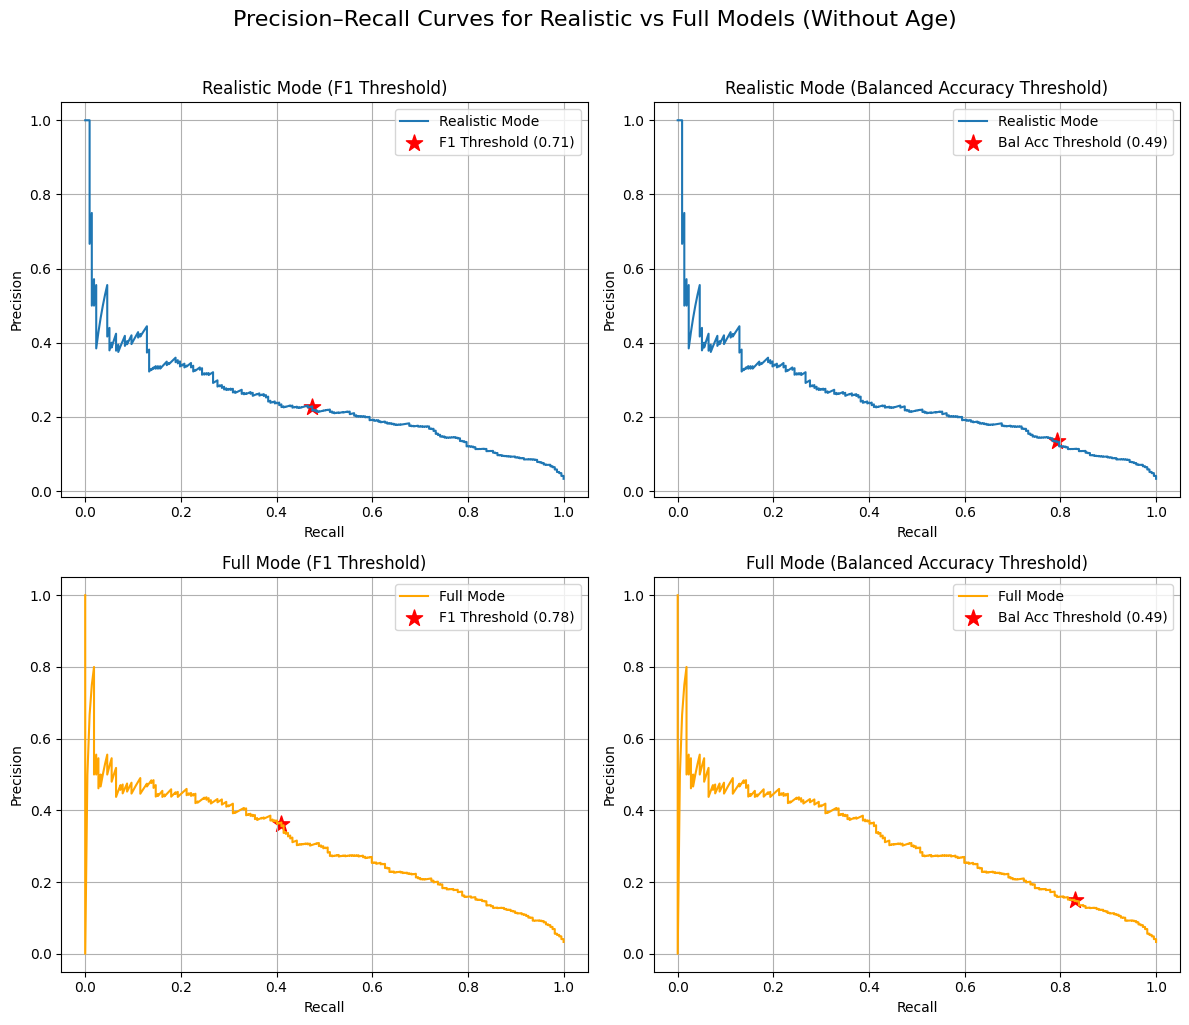

In [4]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# ==============================================================================
# CONFIGURATION
# ==============================================================================
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat',"Age"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# drop CA/PA if realistic - keeping this logic for completeness, but assuming 'full' mode based on user accepting previous 'full' mode code
MODE = "full"
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# Separate X_test for realistic and full models
X_test_realistic = X_test.drop(columns=[c for c in ["CA", "PA", "Growth_Ratio", "Growth_Room"] if c in X_test.columns], errors='ignore')
X_test_full = X_test.copy() # Full mode X_test remains the same


# ==============================================================================
# Plotting Precision-Recall Curves (2x2 Grid)
# ==============================================================================

# Get predicted probabilities for the test set for both models
y_test_pred_prop_realistic = rf_realistic_model['model'].predict_proba(X_test_realistic)[:, 1]
y_test_pred_prop_full = rf_full_model['model'].predict_proba(X_test_full)[:, 1]

# Calculate precision and recall for different thresholds for realistic model
precision_realistic, recall_realistic, thresholds_realistic = precision_recall_curve(y_test, y_test_pred_prop_realistic)

# Calculate precision and recall for different thresholds for full model
precision_full, recall_full, thresholds_full = precision_recall_curve(y_test, y_test_pred_prop_full)

# Get the optimal thresholds from the loaded models
f1_threshold_realistic = rf_realistic_model['thresholds']['F1']
bal_acc_threshold_realistic = rf_realistic_model['thresholds']['Balanced_Accuracy']
f1_threshold_full = rf_full_model['thresholds']['F1']
bal_acc_threshold_full = rf_full_model['thresholds']['Balanced_Accuracy']

# Find the precision and recall values at the optimal thresholds
# Use numpy.argmax with a condition to handle cases where no threshold meets the criteria
f1_idx_realistic = np.argmax(thresholds_realistic >= f1_threshold_realistic) if np.any(thresholds_realistic >= f1_threshold_realistic) else len(thresholds_realistic) - 1
f1_precision_realistic = precision_realistic[f1_idx_realistic]
f1_recall_realistic = recall_realistic[f1_idx_realistic]

bal_acc_idx_realistic = np.argmax(thresholds_realistic >= bal_acc_threshold_realistic) if np.any(thresholds_realistic >= bal_acc_threshold_realistic) else len(thresholds_realistic) - 1
bal_acc_precision_realistic = precision_realistic[bal_acc_idx_realistic]
bal_acc_recall_realistic = recall_realistic[bal_acc_idx_realistic]

f1_idx_full = np.argmax(thresholds_full >= f1_threshold_full) if np.any(thresholds_full >= f1_threshold_full) else len(thresholds_full) - 1
f1_precision_full = precision_full[f1_idx_full]
f1_recall_full = recall_full[f1_idx_full]

bal_acc_idx_full = np.argmax(thresholds_full >= bal_acc_threshold_full) if np.any(thresholds_full >= bal_acc_threshold_full) else len(thresholds_full) - 1
bal_acc_precision_full = precision_full[bal_acc_idx_full]
bal_acc_recall_full = recall_full[bal_acc_idx_full]


# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Realistic Mode (F1 Threshold)
axes[0, 0].plot(recall_realistic, precision_realistic, label='Realistic Mode', linestyle='-')  
axes[0, 0].scatter(f1_recall_realistic, f1_precision_realistic, color='red', marker='*', s=150,
                   label=f'F1 Threshold ({f1_threshold_realistic:.2f})')
axes[0, 0].set_xlabel("Recall")
axes[0, 0].set_ylabel("Precision")
axes[0, 0].set_title("Realistic Mode (F1 Threshold)")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot Realistic Mode (Balanced Accuracy Threshold)
axes[0, 1].plot(recall_realistic, precision_realistic, label='Realistic Mode', linestyle='-')  
axes[0, 1].scatter(bal_acc_recall_realistic, bal_acc_precision_realistic, color='red', marker='*', s=150,
                   label=f'Bal Acc Threshold ({bal_acc_threshold_realistic:.2f})')
axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].set_title("Realistic Mode (Balanced Accuracy Threshold)")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot Full Mode (F1 Threshold)
axes[1, 0].plot(recall_full, precision_full, label='Full Mode', color='orange', linestyle='-')  
axes[1, 0].scatter(f1_recall_full, f1_precision_full, color='red', marker='*', s=150,
                   label=f'F1 Threshold ({f1_threshold_full:.2f})')
axes[1, 0].set_xlabel("Recall")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].set_title("Full Mode (F1 Threshold)")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot Full Mode (Balanced Accuracy Threshold)
axes[1, 1].plot(recall_full, precision_full, label='Full Mode', color='orange', linestyle='-')  
axes[1, 1].scatter(bal_acc_recall_full, bal_acc_precision_full, color='red', marker='*', s=150,
                   label=f'Bal Acc Threshold ({bal_acc_threshold_full:.2f})')
axes[1, 1].set_xlabel("Recall")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].set_title("Full Mode (Balanced Accuracy Threshold)")
axes[1, 1].legend()
axes[1, 1].grid(True)

fig.suptitle(
    "Precision–Recall Curves for Realistic vs Full Models (Without Age)",
    fontsize=16,
    y=1.02
)

plt.tight_layout()
plt.savefig("precision_recall_4grid.png") 
plt.show()

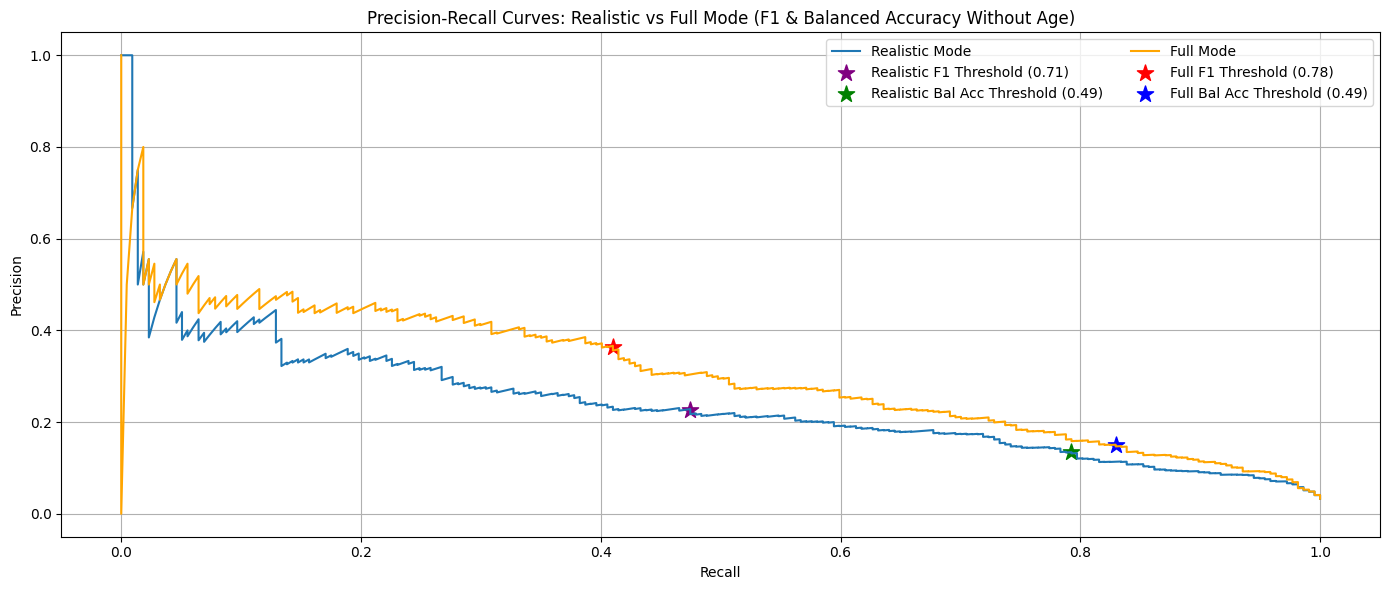

In [5]:
plt.figure(figsize=(14, 6))

#  Realistic Mode
plt.plot(recall_realistic, precision_realistic, label='Realistic Mode', linestyle='-')
plt.scatter(f1_recall_realistic, f1_precision_realistic, color='purple', marker='*', s=150,
            label=f'Realistic F1 Threshold ({f1_threshold_realistic:.2f})')
plt.scatter(bal_acc_recall_realistic, bal_acc_precision_realistic, color='green', marker='*', s=150,
            label=f'Realistic Bal Acc Threshold ({bal_acc_threshold_realistic:.2f})')

#  Full Mode 
plt.plot(recall_full, precision_full, label='Full Mode', color='orange', linestyle='-')
plt.scatter(f1_recall_full, f1_precision_full, color='red', marker='*', s=150,
            label=f'Full F1 Threshold ({f1_threshold_full:.2f})')
plt.scatter(bal_acc_recall_full, bal_acc_precision_full, color='blue', marker='*', s=150,
            label=f'Full Bal Acc Threshold ({bal_acc_threshold_full:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves: Realistic vs Full Mode (F1 & Balanced Accuracy Without Age)")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_combined.png")
plt.show()

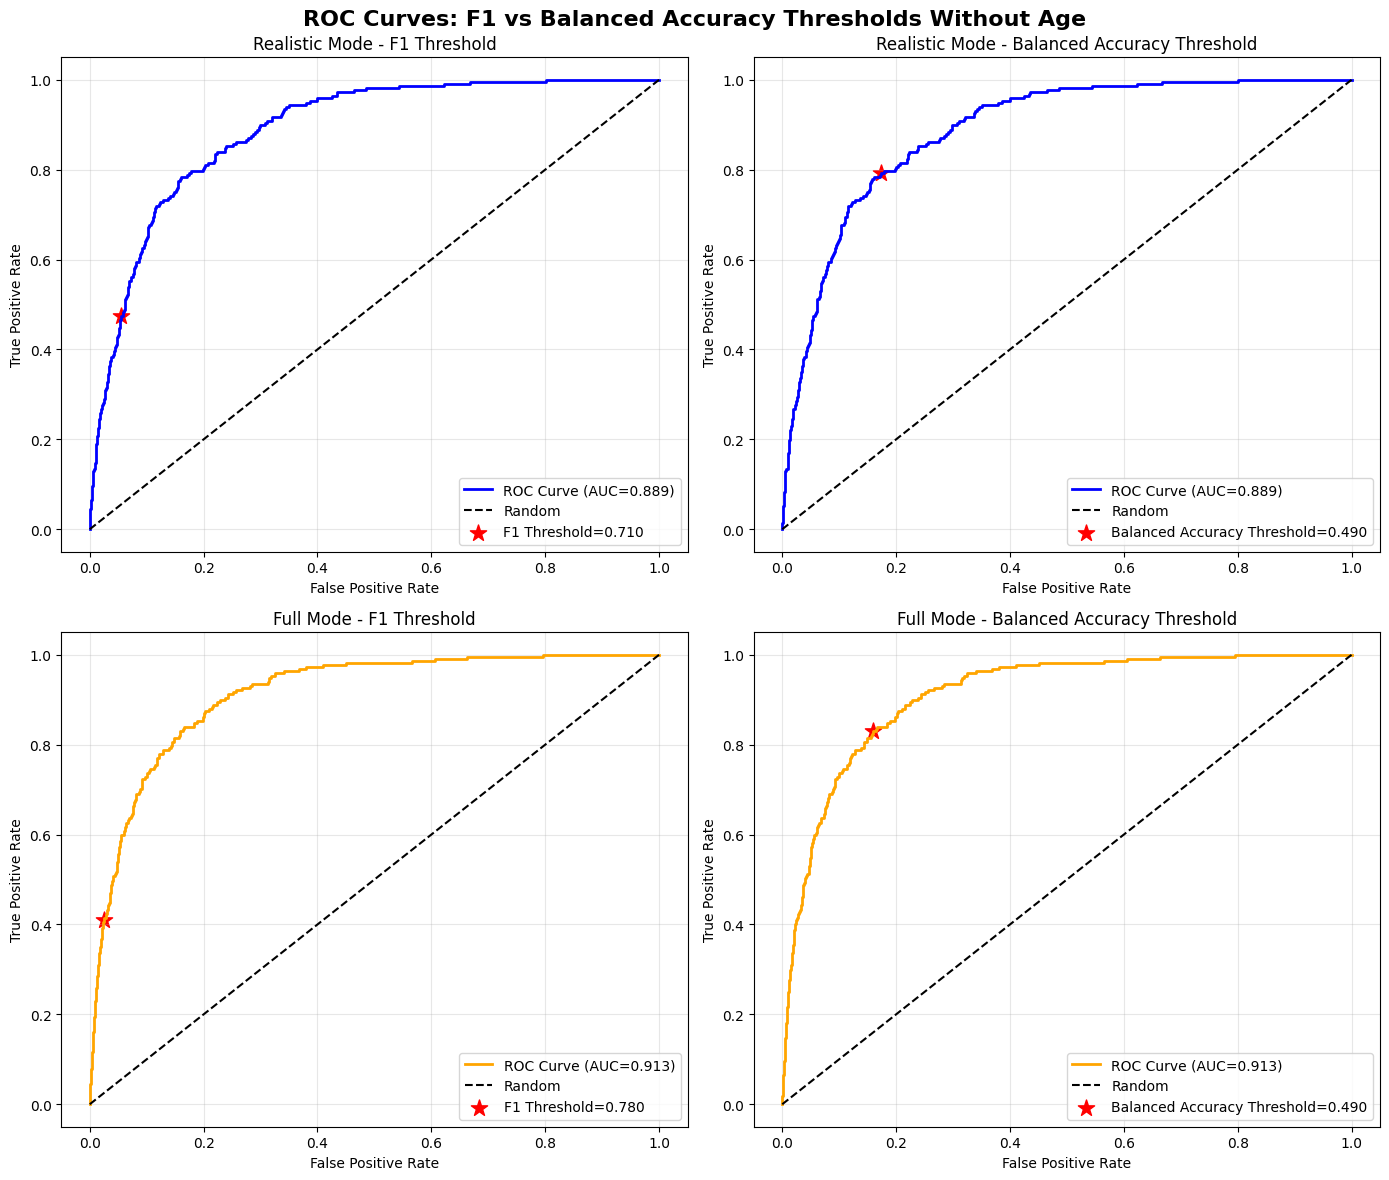

In [6]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Helper function to compute FPR/TPR for a threshold
def roc_point(y_true, y_pred_prop, threshold):
    y_pred = (y_pred_prop >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('ROC Curves: F1 vs Balanced Accuracy Thresholds Without Age', fontsize=16, fontweight='bold')

# -----------------------------
# Realistic Mode
# -----------------------------
fpr_real, tpr_real, _ = roc_curve(y_test, y_test_pred_prop_realistic)
roc_auc_real = auc(fpr_real, tpr_real)

# F1 Threshold
fpr_f1_real, tpr_f1_real = roc_point(y_test, y_test_pred_prop_realistic, rf_realistic_model['thresholds']['F1'])
axes[0, 0].plot(fpr_real, tpr_real, 'b-', linewidth=2, label=f'ROC Curve (AUC={roc_auc_real:.3f})')
axes[0, 0].plot([0,1], [0,1], 'k--', label='Random')
axes[0, 0].scatter(fpr_f1_real, tpr_f1_real, color='red', s=150, marker='*',
                   label=f'F1 Threshold={rf_realistic_model["thresholds"]["F1"]:.3f}')
axes[0, 0].set_title('Realistic Mode - F1 Threshold')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(loc='best')

# Balanced Accuracy Threshold
fpr_bal_real, tpr_bal_real = roc_point(y_test, y_test_pred_prop_realistic, rf_realistic_model['thresholds']['Balanced_Accuracy'])
axes[0, 1].plot(fpr_real, tpr_real, 'b-', linewidth=2, label=f'ROC Curve (AUC={roc_auc_real:.3f})')
axes[0, 1].plot([0,1], [0,1], 'k--', label='Random')
axes[0, 1].scatter(fpr_bal_real, tpr_bal_real, color='red', s=150, marker='*',
                   label=f'Balanced Accuracy Threshold={rf_realistic_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[0, 1].set_title('Realistic Mode - Balanced Accuracy Threshold')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(loc='best')

# -----------------------------
# Full Mode
# -----------------------------
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_pred_prop_full)
roc_auc_full = auc(fpr_full, tpr_full)

# F1 Threshold
fpr_f1_full, tpr_f1_full = roc_point(y_test, y_test_pred_prop_full, rf_full_model['thresholds']['F1'])
axes[1, 0].plot(fpr_full, tpr_full, 'orange', linewidth=2, label=f'ROC Curve (AUC={roc_auc_full:.3f})')
axes[1, 0].plot([0,1], [0,1], 'k--', label='Random')
axes[1, 0].scatter(fpr_f1_full, tpr_f1_full, color='red', s=150, marker='*',
                   label=f'F1 Threshold={rf_full_model["thresholds"]["F1"]:.3f}')
axes[1, 0].set_title('Full Mode - F1 Threshold')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(loc='best')

# Balanced Accuracy Threshold
fpr_bal_full, tpr_bal_full = roc_point(y_test, y_test_pred_prop_full, rf_full_model['thresholds']['Balanced_Accuracy'])
axes[1, 1].plot(fpr_full, tpr_full, 'orange', linewidth=2, label=f'ROC Curve (AUC={roc_auc_full:.3f})')
axes[1, 1].plot([0,1], [0,1], 'k--', label='Random')
axes[1, 1].scatter(fpr_bal_full, tpr_bal_full, color='red', s=150, marker='*',
                   label=f'Balanced Accuracy Threshold={rf_full_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[1, 1].set_title('Full Mode - Balanced Accuracy Threshold')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(loc='best')

plt.tight_layout()
plt.savefig("roc_2x2_grid.png", dpi=300, bbox_inches='tight')
plt.show()

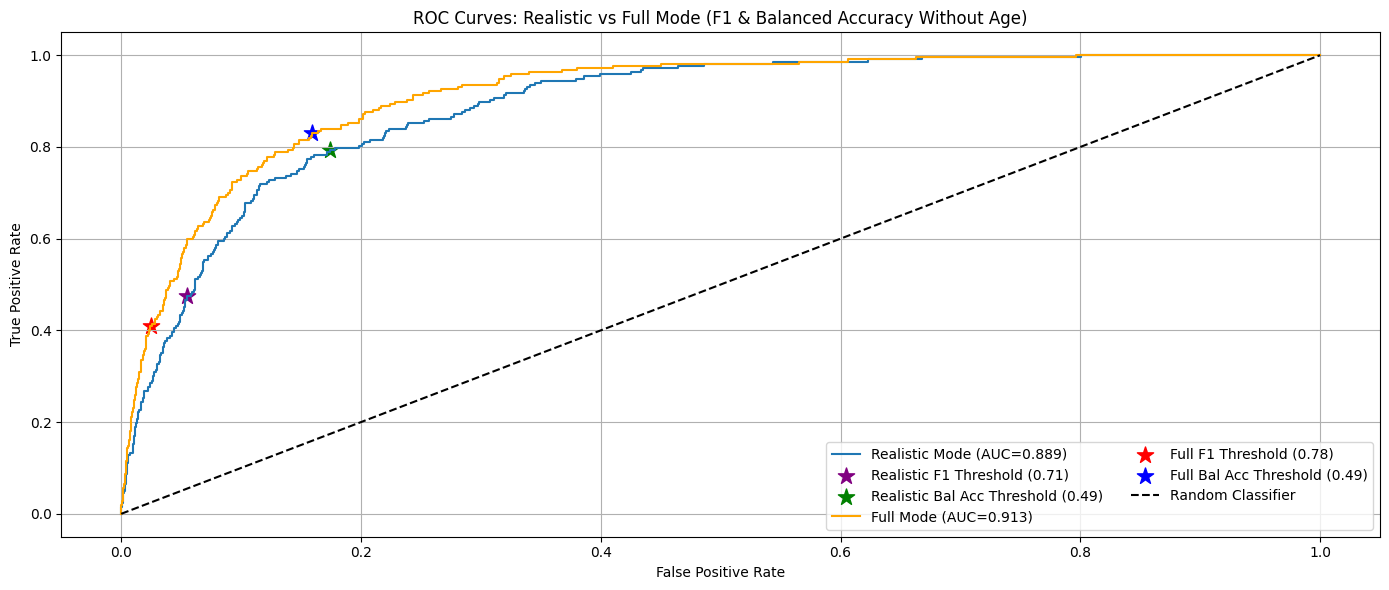

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curves
fpr_real, tpr_real, _ = roc_curve(y_test, y_test_pred_prop_realistic)
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_pred_prop_full)

roc_auc_real = auc(fpr_real, tpr_real)
roc_auc_full = auc(fpr_full, tpr_full)

# Compute points for thresholds
def roc_point(y_true, y_pred_prop, threshold):
    y_pred = (y_pred_prop >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

fpr_f1_real, tpr_f1_real = roc_point(y_test, y_test_pred_prop_realistic, rf_realistic_model['thresholds']['F1'])
fpr_bal_real, tpr_bal_real = roc_point(y_test, y_test_pred_prop_realistic, rf_realistic_model['thresholds']['Balanced_Accuracy'])

fpr_f1_full, tpr_f1_full = roc_point(y_test, y_test_pred_prop_full, rf_full_model['thresholds']['F1'])
fpr_bal_full, tpr_bal_full = roc_point(y_test, y_test_pred_prop_full, rf_full_model['thresholds']['Balanced_Accuracy'])

# Plot combined ROC
plt.figure(figsize=(14, 6))

#  Realistic Mode
plt.plot(fpr_real, tpr_real, label=f'Realistic Mode (AUC={roc_auc_real:.3f})', linestyle='-')
plt.scatter(fpr_f1_real, tpr_f1_real, color='purple', marker='*', s=150,
            label=f'Realistic F1 Threshold ({rf_realistic_model["thresholds"]["F1"]:.2f})')
plt.scatter(fpr_bal_real, tpr_bal_real, color='green', marker='*', s=150,
            label=f'Realistic Bal Acc Threshold ({rf_realistic_model["thresholds"]["Balanced_Accuracy"]:.2f})')

#  Full Mode 
plt.plot(fpr_full, tpr_full, label=f'Full Mode (AUC={roc_auc_full:.3f})', color='orange', linestyle='-')
plt.scatter(fpr_f1_full, tpr_f1_full, color='red', marker='*', s=150,
            label=f'Full F1 Threshold ({rf_full_model["thresholds"]["F1"]:.2f})')
plt.scatter(fpr_bal_full, tpr_bal_full, color='blue', marker='*', s=150,
            label=f'Full Bal Acc Threshold ({rf_full_model["thresholds"]["Balanced_Accuracy"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Realistic vs Full Mode (F1 & Balanced Accuracy Without Age)")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_combined.png", dpi=300)
plt.show()

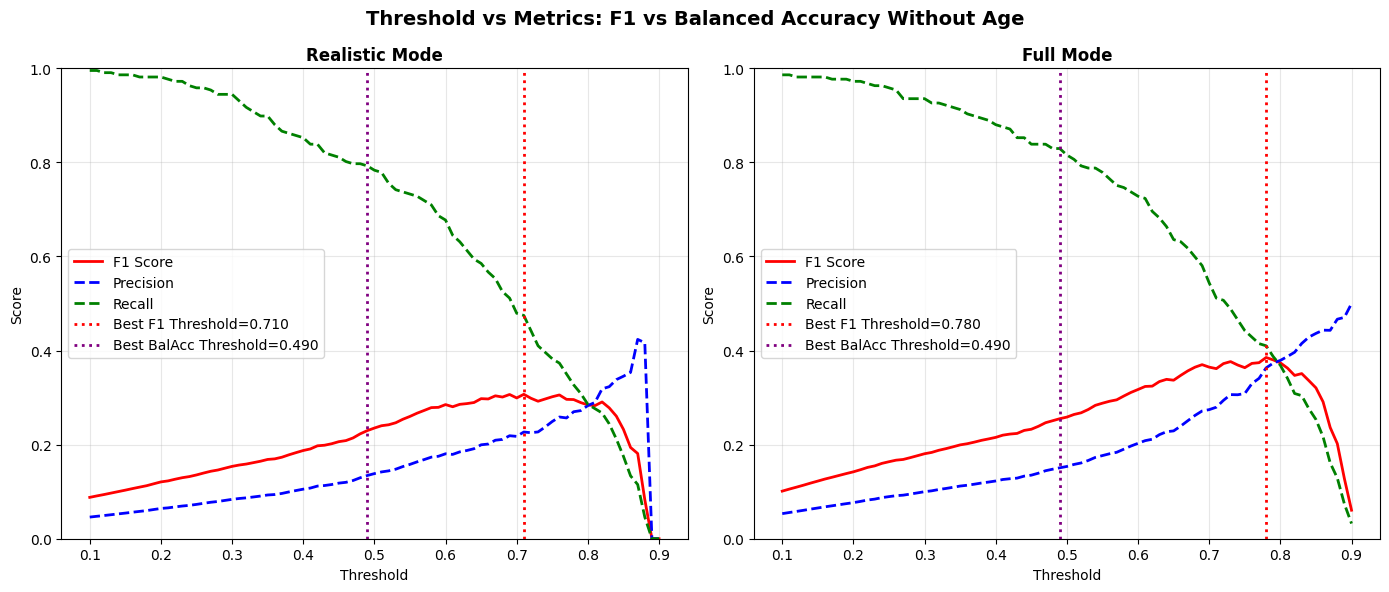

In [8]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Define threshold range
threshold_range = np.arange(0.1, 0.91, 0.01)

def compute_metrics(y_true, y_pred_prop, threshold_range):
    f1_scores, bal_acc_scores, precision_scores, recall_scores = [], [], [], []
    for t in threshold_range:
        y_pred_t = (y_pred_prop >= t).astype(int)
        # Set zero_division=0 to handle cases with no positive predictions
        f1_scores.append(f1_score(y_true, y_pred_t, zero_division=0))
        bal_acc_scores.append(balanced_accuracy_score(y_true, y_pred_t))
        precision_scores.append(precision_score(y_true, y_pred_t, zero_division=0))
        recall_scores.append(recall_score(y_true, y_pred_t, zero_division=0))
    return f1_scores, bal_acc_scores, precision_scores, recall_scores

#  Realistic Mode
f1_scores_real, bal_acc_scores_real, precision_scores_real, recall_scores_real = compute_metrics(
    y_test, y_test_pred_prop_realistic, threshold_range
)

#  Full Mode 
f1_scores_full, bal_acc_scores_full, precision_scores_full, recall_scores_full = compute_metrics(
    y_test, y_test_pred_prop_full, threshold_range
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Threshold vs Metrics: F1 vs Balanced Accuracy Without Age', fontsize=14, fontweight='bold')

#  Realistic Mode
axes[0].plot(threshold_range, f1_scores_real, 'r-', linewidth=2, label='F1 Score')
axes[0].plot(threshold_range, precision_scores_real, 'b--', linewidth=2, label='Precision')
axes[0].plot(threshold_range, recall_scores_real, 'g--', linewidth=2, label='Recall')
axes[0].axvline(rf_realistic_model['thresholds']['F1'], color='red', linestyle=':', linewidth=2,
                label=f'Best F1 Threshold={rf_realistic_model["thresholds"]["F1"]:.3f}')
axes[0].axvline(rf_realistic_model['thresholds']['Balanced_Accuracy'], color='purple', linestyle=':', linewidth=2,
                label=f'Best BalAcc Threshold={rf_realistic_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[0].set_title('Realistic Mode', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best')
axes[0].set_ylim([0, 1])

#  Full Mode 
axes[1].plot(threshold_range, f1_scores_full, 'r-', linewidth=2, label='F1 Score')
axes[1].plot(threshold_range, precision_scores_full, 'b--', linewidth=2, label='Precision')
axes[1].plot(threshold_range, recall_scores_full, 'g--', linewidth=2, label='Recall')
axes[1].axvline(rf_full_model['thresholds']['F1'], color='red', linestyle=':', linewidth=2,
                label=f'Best F1 Threshold={rf_full_model["thresholds"]["F1"]:.3f}')
axes[1].axvline(rf_full_model['thresholds']['Balanced_Accuracy'], color='purple', linestyle=':', linewidth=2,
                label=f'Best BalAcc Threshold={rf_full_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[1].set_title('Full Mode', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig("threshold_vs_metrics_pair_combined.png", dpi=300, bbox_inches='tight')
plt.show()

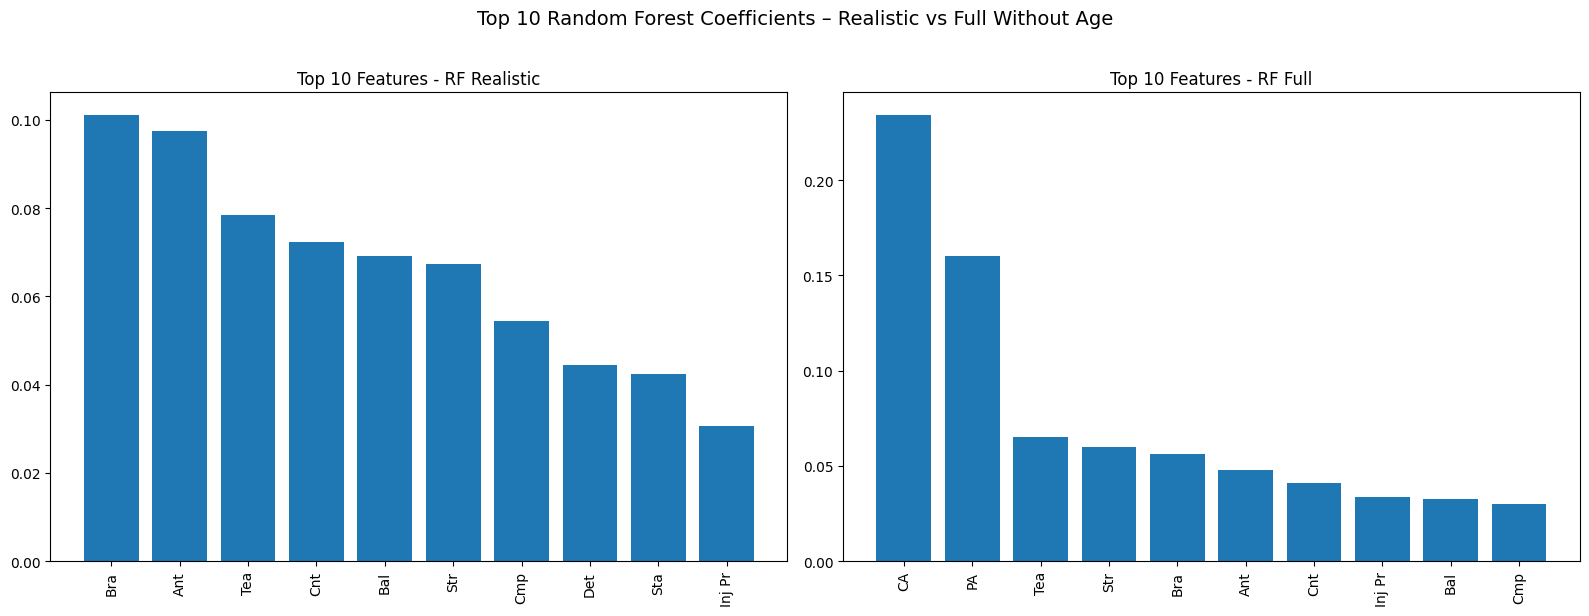

RF Realistic Top 10 Features:
Bra: 0.1012
Ant: 0.0974
Tea: 0.0785
Cnt: 0.0723
Bal: 0.0692
Str: 0.0673
Cmp: 0.0545
Det: 0.0446
Sta: 0.0423
Inj Pr: 0.0306

RF Full Top 10 Features:
CA: 0.2344
PA: 0.1603
Tea: 0.0655
Str: 0.0599
Bra: 0.0562
Ant: 0.0477
Cnt: 0.0413
Inj Pr: 0.0335
Bal: 0.0327
Cmp: 0.0300


In [10]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load saved RF models
model_rf_realistic = joblib.load("RF_realistic_model.pkl")["model"]
model_rf_full = joblib.load("RF_full_model.pkl")["model"]

# Extract feature importances
importances_realistic = model_rf_realistic.named_steps["clf"].feature_importances_
importances_full = model_rf_full.named_steps["clf"].feature_importances_

# Get feature names from the fitted models
X_realistic_cols = model_rf_realistic.named_steps["clf"].feature_names_in_
X_full_cols = model_rf_full.named_steps["clf"].feature_names_in_


# Get top 10 indices
top_n = 10
indices_realistic = np.argsort(importances_realistic)[::-1][:top_n]
indices_full = np.argsort(importances_full)[::-1][:top_n]

# Top features and importances
top_features_realistic = [X_realistic_cols[i] for i in indices_realistic]
top_importances_realistic = importances_realistic[indices_realistic]

top_features_full = [X_full_cols[i] for i in indices_full]
top_importances_full = importances_full[indices_full]

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].bar(range(top_n), top_importances_realistic, align='center')
axes[0].set_xticks(range(top_n))
axes[0].set_xticklabels(top_features_realistic, rotation=90)
axes[0].set_title("Top 10 Features - RF Realistic")

axes[1].bar(range(top_n), top_importances_full, align='center')
axes[1].set_xticks(range(top_n))
axes[1].set_xticklabels(top_features_full, rotation=90)
axes[1].set_title("Top 10 Features - RF Full")

fig.suptitle("Top 10 Random Forest Coefficients – Realistic vs Full Without Age", fontsize=14, y=1.02)


plt.tight_layout()
plt.savefig("top_10_features_comparison.png")
plt.show()

# Print top 10 features side by side
print("RF Realistic Top 10 Features:")
for f, imp in zip(top_features_realistic, top_importances_realistic):
    print(f"{f}: {imp:.4f}")

print("\nRF Full Top 10 Features:")
for f, imp in zip(top_features_full, top_importances_full):
    print(f"{f}: {imp:.4f}")